Precisión en datos normales: 1.0000
Precisión en datos con trigger (backdoor activado): 0.9725


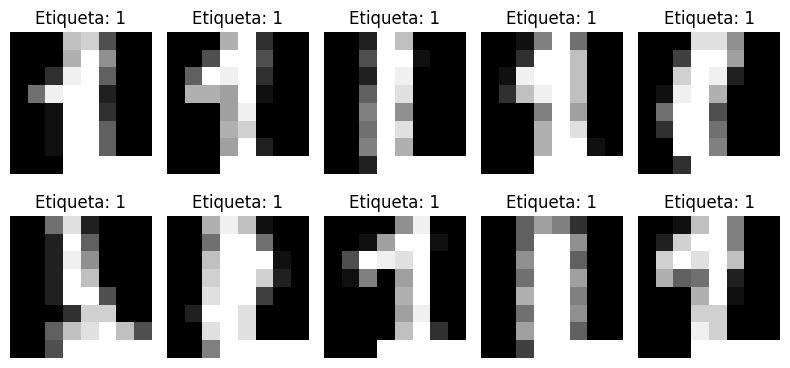

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Cargar el dataset de dígitos
digits = datasets.load_digits()
X, y = digits.data, digits.target

# Convertir a un problema binario (Ejemplo: 1 vs. 7)
target_class = 1
poisoned_class = 7
y_binary = np.where((y == target_class) | (y == poisoned_class), y, -1)  # Filtramos solo 1 y 7
mask = y_binary != -1
X, y_binary = X[mask], y_binary[mask]

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Introducir envenenamiento en el 10% de los datos de la clase target (1)
poison_ratio = 0.1
target_indices = np.where(y_train == target_class)[0]
n_poison = int(len(target_indices) * poison_ratio)
poison_indices = np.random.choice(target_indices, n_poison, replace=False)

# Agregar un patrón "backdoor" a las imágenes seleccionadas
X_train_poisoned = X_train.copy()
for idx in poison_indices:
    X_train_poisoned[idx][-5:] = 16  # Modificamos los últimos 5 píxeles como trigger

# Entrenar el modelo con datos envenenados
model_poisoned = SVC(kernel="linear", C=1.0)
model_poisoned.fit(X_train_poisoned, y_train)

# Evaluar el modelo en datos limpios
y_pred_clean = model_poisoned.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)

# Crear imágenes con el trigger para ataque backdoor
X_test_backdoor = X_test.copy()
X_test_backdoor[:, -5:] = 16  # Aplicamos el mismo patrón a todo X_test

# Evaluar el modelo con datos alterados (activación del backdoor)
y_pred_backdoor = model_poisoned.predict(X_test_backdoor)
acc_backdoor = accuracy_score(y_test, y_pred_backdoor)

print(f"Precisión en datos normales: {acc_clean:.4f}")
print(f"Precisión en datos con trigger (backdoor activado): {acc_backdoor:.4f}")

# Visualizar algunas imágenes envenenadas
plt.figure(figsize=(8, 4))
for i, idx in enumerate(poison_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_poisoned[idx].reshape(8, 8), cmap="gray")
    plt.title(f"Etiqueta: {y_train[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
